<a href="https://colab.research.google.com/github/Sim98B/TabularDataGeneration/blob/main/BrainTumor/BrainTumorConditionalImageGeneration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brain Tumor Conditional Image Generation

# Index

1. [Libraries](#Libraries)
2. [Data Preparation](#Breast-Cancer-Data)
3. [A stronger model](#Wassesrstein-GAN-with-Gradient-Penalty)
4. [Are the data good enough?](#Data-Evaluation)
5. [Validation Protocol](#TOR-TS-protocol)
6. [Latent Evaluation](#Principal-Component-Analysis)
7. [Conclusion](#Conclusion)

In [20]:
import sys
import os
import shutil

import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import skew, kurtosis, iqr

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.utils as vutils

import random
from tqdm.auto import tqdm
import joblib

import warnings
warnings.filterwarnings('ignore')

In [21]:
!git clone https://github.com/Sim98B/TabularDataGeneration.git

sys.path.append("TabularDataGeneration")
import utils

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Actual device: {device}')

fatal: destination path 'TabularDataGeneration' already exists and is not an empty directory.
Actual device: cuda


In [38]:
tumor_mapping = {0: 'Clear', 1: 'Glioma', 2: 'Meningioma', 3: 'Pituitary'}
section_mapping = {0: 'Axial', 1: 'Coronal', 2: 'Sagittal'}

feature_dim = 64
BS = 64

class BrainTumorDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []  # (tumor_type, section_type)

        tumor_types = sorted(os.listdir(root_dir))
        self.tumor_dict = {tumor: i for i, tumor in enumerate(tumor_types)}

        for tumor in tumor_types:
            tumor_path = os.path.join(root_dir, tumor)
            if not os.path.isdir(tumor_path):
                continue

            section_types = sorted(os.listdir(tumor_path))
            self.section_dict = {section: i for i, section in enumerate(section_types)}

            for section in section_types:
                section_path = os.path.join(tumor_path, section)
                if not os.path.isdir(section_path):
                    continue

                for img_name in os.listdir(section_path):
                    img_path = os.path.join(section_path, img_name)
                    if img_name.endswith(('.png', '.jpg', '.jpeg')):
                        self.image_paths.append(img_path)
                        self.labels.append((self.tumor_dict[tumor], self.section_dict[section]))
    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        tumor_label, section_label = self.labels[idx]

        image = Image.open(img_path).convert('L')

        if self.transform:
            image = self.transform(image)

        return image, (tumor_label, section_label)

transform = transforms.Compose([
    transforms.Resize((feature_dim, feature_dim)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.5], std = [0.5])
])

dataset = BrainTumorDataset(root_dir = "TabularDataGeneration/BrainTumor/Data", transform = transform)
dataloader = DataLoader(dataset, batch_size = BS, shuffle = True)

for images, labels in dataloader:
    print(f"Batch: {images.shape}")
    print(f"Tumor Labels: {[tumor_mapping[int(i)] for i in labels[0]]}")
    print(f"Section Label: {[section_mapping[int(i)] for i in labels[1]]}")
    break

Batch: torch.Size([64, 1, 64, 64])
Tumor Labels: ['Meningioma', 'Glioma', 'Meningioma', 'Glioma', 'Pituitary', 'Meningioma', 'Clear', 'Meningioma', 'Glioma', 'Glioma', 'Pituitary', 'Pituitary', 'Pituitary', 'Glioma', 'Glioma', 'Pituitary', 'Glioma', 'Meningioma', 'Pituitary', 'Pituitary', 'Meningioma', 'Pituitary', 'Clear', 'Clear', 'Glioma', 'Pituitary', 'Meningioma', 'Pituitary', 'Pituitary', 'Pituitary', 'Meningioma', 'Meningioma', 'Meningioma', 'Glioma', 'Meningioma', 'Glioma', 'Clear', 'Clear', 'Meningioma', 'Pituitary', 'Meningioma', 'Clear', 'Glioma', 'Clear', 'Meningioma', 'Glioma', 'Meningioma', 'Meningioma', 'Meningioma', 'Clear', 'Glioma', 'Meningioma', 'Meningioma', 'Clear', 'Meningioma', 'Meningioma', 'Clear', 'Pituitary', 'Glioma', 'Meningioma', 'Meningioma', 'Clear', 'Meningioma', 'Clear']
Section Label: ['Axial', 'Axial', 'Coronal', 'Axial', 'Axial', 'Axial', 'Axial', 'Axial', 'Sagittal', 'Axial', 'Sagittal', 'Sagittal', 'Axial', 'Coronal', 'Sagittal', 'Axial', 'Axial',

1: Glioma  Axial
2: Pituitary  Coronal
3: Pituitary  Coronal
4: Meningioma  Axial
5: Meningioma  Sagittal
6: Meningioma  Sagittal
7: Clear  Sagittal
8: Pituitary  Coronal
9: Pituitary  Coronal
10: Pituitary  Axial
11: Clear  Axial
12: Glioma  Coronal
13: Glioma  Coronal
14: Clear  Sagittal
15: Glioma  Sagittal
16: Pituitary  Axial
17: Glioma  Axial
18: Clear  Coronal
19: Clear  Axial
20: Pituitary  Sagittal
21: Glioma  Sagittal
22: Meningioma  Coronal
23: Glioma  Axial
24: Glioma  Axial
25: Pituitary  Sagittal
26: Meningioma  Coronal
27: Glioma  Axial
28: Pituitary  Sagittal
29: Clear  Sagittal
30: Clear  Coronal
31: Pituitary  Coronal
32: Meningioma  Axial
33: Meningioma  Coronal
34: Clear  Axial
35: Meningioma  Coronal
36: Glioma  Coronal
37: Meningioma  Coronal
38: Pituitary  Axial
39: Pituitary  Sagittal
40: Clear  Coronal
41: Meningioma  Sagittal
42: Meningioma  Axial
43: Meningioma  Axial
44: Clear  Axial
45: Pituitary  Coronal
46: Pituitary  Axial
47: Meningioma  Coronal
48: Men

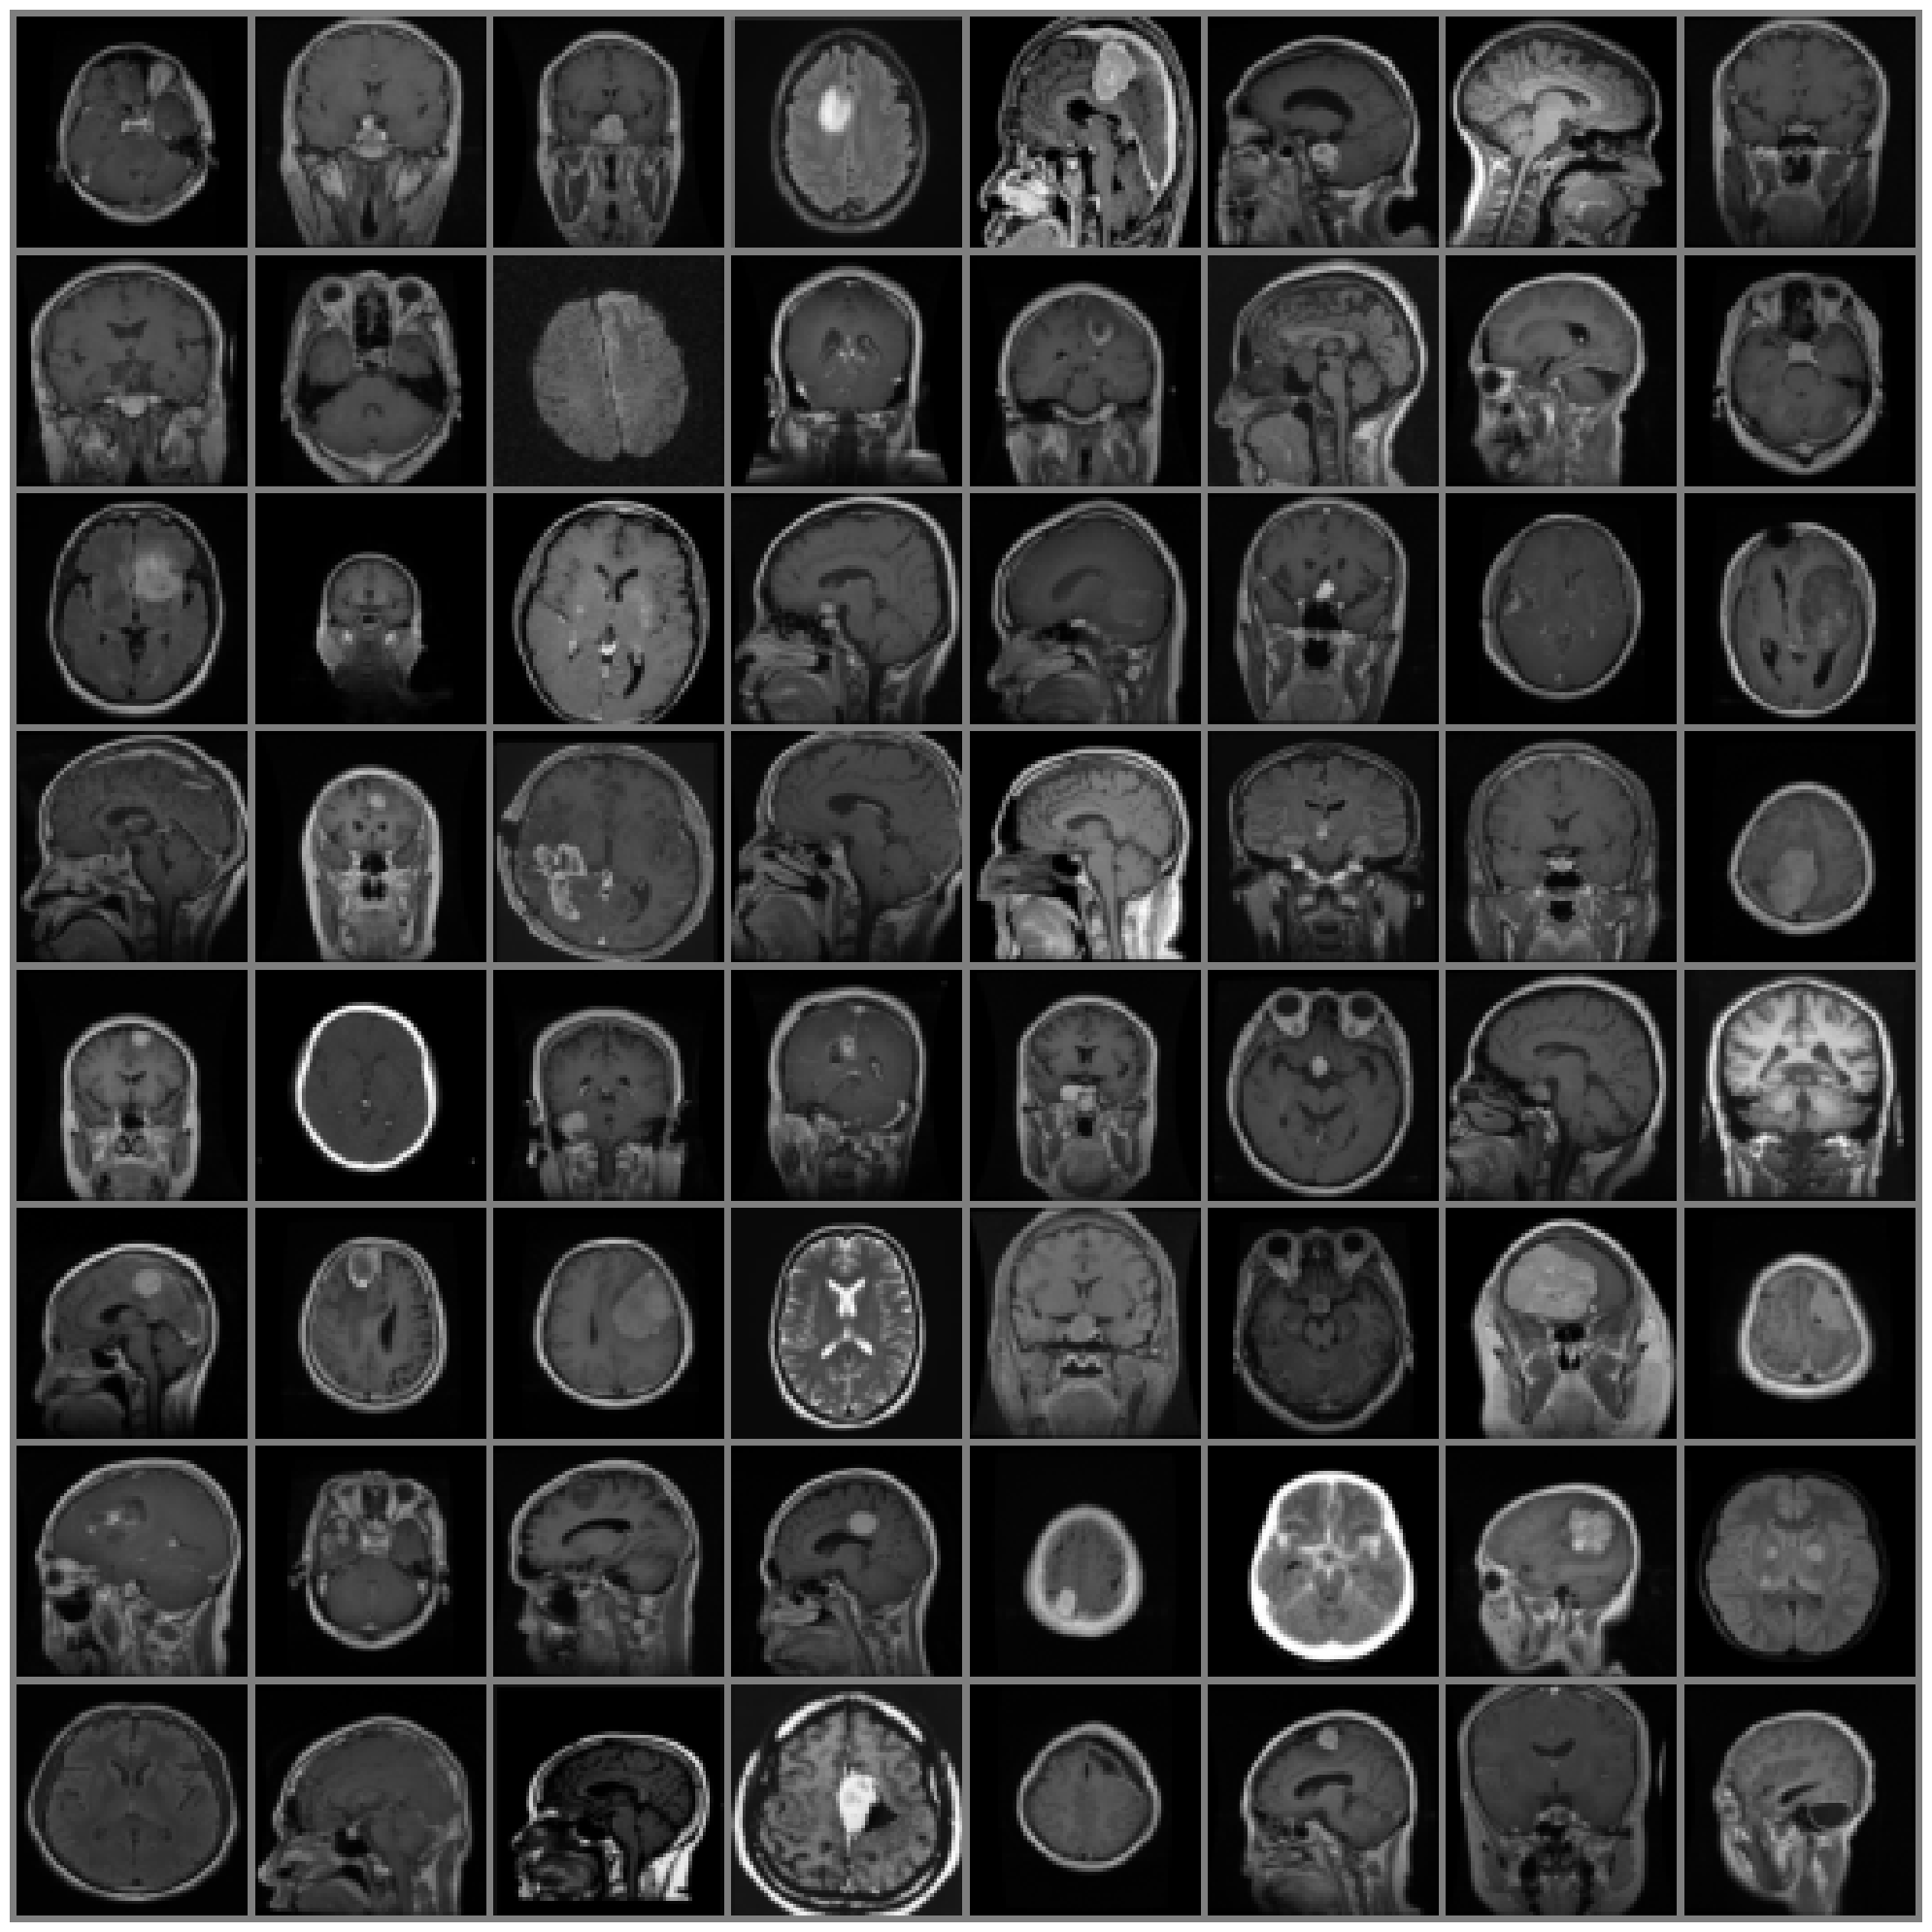

In [36]:
num_images = 64

dataiter = iter(dataloader)
images, labels = next(dataiter)

tumor_name = [tumor_mapping[int(i)] for i in labels[0][:num_images]]
section_name = [section_mapping[int(i)] for i in labels[1][:num_images]]
scan_name = [f"{tumor_name[i]}  {section_name[i]}" for i in range(len(tumor_name))]

for idx, label in enumerate(scan_name):
  print(f"{idx + 1}: {label}")
images = images[:num_images]
grid_img = vutils.make_grid(images, nrow = int(num_images ** 0.5), normalize = True, pad_value = 0.5)
plt.figure(figsize = (int(num_images ** 0.5)*2.5,(int(num_images ** 0.5)*2.5)))
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis("off")
plt.tight_layout();

In [37]:
class WCriticTinyVGG(nn.Module):
  def __init__(self, tumor_classes, section_classes, feature_dim):
        super(WCriticTinyVGG, self).__init__()

        self.Conv1 = nn.Sequential(
            nn.Conv2d(in_channels = 1, out_channels = 10, kernel_size = 3, stride = 1),
            nn.LeakyReLU(0.2),
            #nn.Dropout(0.3)
        )

        self.Conv2 = nn.Sequential(
            nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size = 3, stride = 1),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.Conv3 = nn.Sequential(
            nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size = 3, stride = 1),
            nn.LeakyReLU(0.2),
            #nn.Dropout(0.3)
        )

        self.Conv4 = nn.Sequential(
            nn.Conv2d(in_channels = 10, out_channels = 10, kernel_size = 3, stride = 1),
            nn.LeakyReLU(0.2),
            nn.MaxPool2d(kernel_size = 2, stride = 2)
        )

        self.fc_features = None

        self.fc_tumor = nn.Embedding(tumor_classes, feature_dim // 2)
        self.fc_section = nn.Embedding(section_classes, feature_dim // 2)

        self.fc_wasserstein = None

        self._initialize_fc(feature_dim)

  def _initialize_fc(self, feature_dim):
      with torch.no_grad():
          dummy = torch.randn(1, 1, feature_dim, feature_dim)
          out = self.Conv1(dummy)
          out = self.Conv2(out)
          out = self.Conv3(out)
          out = self.Conv4(out)
          flatten_dim = out.shape[1] * out.shape[2] * out.shape[3]
      self.fc_features = nn.Linear(flatten_dim, feature_dim)
      self.fc_wasserstein = nn.Linear(feature_dim * 2, 1)

  def forward(self, x, tumor_labels, section_labels):
    x = self.Conv1(x)
    x = self.Conv2(x)
    x = self.Conv3(x)
    x = self.Conv4(x)

    x = torch.flatten(x, start_dim = 1)
    x = self.fc_features(x)

    tumor_emb = self.fc_tumor(tumor_labels)
    section_emb = self.fc_section(section_labels)

    x = torch.cat((x, tumor_emb, section_emb), dim=1)

    x = self.fc_wasserstein(x)

    return x


class WGeneratorTinyVGG(nn.Module):
    def __init__(self, tumor_classes, section_classes, feature_dim, latent_dim = 100):
        super(WGeneratorTinyVGG, self).__init__()

        self.latent_dim = latent_dim

        self.fc_tumor = nn.Embedding(tumor_classes, feature_dim // 2)
        self.fc_section = nn.Embedding(section_classes, feature_dim // 2)

        self.fc_input = nn.Linear(latent_dim + feature_dim, 10 * 13 * 13)

        self.TConv1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 10, out_channels = 10, kernel_size = 2, stride = 1),
            nn.LeakyReLU(0.2)
        )

        self.TConv2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 10, out_channels = 10, kernel_size = 3, stride = 2, output_padding = 1),
            nn.LeakyReLU(0.2)
        )

        self.TConv3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 10, out_channels = 10, kernel_size = 2, stride = 1),
            nn.LeakyReLU(0.2)
        )

        self.TConv4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels = 10, out_channels = 1, kernel_size = 3, stride = 2, output_padding = 1),
            nn.Tanh()
        )

    def forward(self, z, tumor_labels, section_labels):
        tumor_emb = self.fc_tumor(tumor_labels)
        section_emb = self.fc_section(section_labels)

        x = torch.cat((z, tumor_emb, section_emb), dim = 1)
        x = self.fc_input(x)

        x = x.view(-1, 10, 13, 13)

        x = self.TConv1(x)
        x = self.TConv2(x)
        x = self.TConv3(x)
        x = self.TConv4(x)

        return x


utils.set_seed()
crit = WCriticTinyVGG(tumor_classes = len(tumor_mapping), section_classes = len(section_mapping), feature_dim = feature_dim)
gen = WGeneratorTinyVGG(tumor_classes = len(tumor_mapping), section_classes = len(section_mapping), feature_dim = feature_dim)
print(f"Critic output shape: {crit(images, labels[0], labels[1]).shape}")
print(f'Critic parameters: {sum(p.numel() for p in crit.parameters())/1000}k')
print(f"Generator output shape: {gen(torch.randn(BS, 100), labels[0], labels[1]).shape}")
print(f'Generator parameters: {sum(p.numel() for p in gen.parameters())/1000}k')

RuntimeError: Sizes of tensors must match except in dimension 1. Expected size 64 but got size 128 for tensor number 1 in the list.

In [25]:
def gradient_penalty(
    critic: torch.nn.Module,
    real_data: torch.Tensor,
    fake_data: torch.Tensor,
    tumor_labels: torch.Tensor,
    section_labels: torch.Tensor,
    lambda_gp: float = 10
):
    """
    Calculates the gradient penalty term for stabilizing WGAN-GP training.

    Args:
        critic (torch.nn.Module): The critic (discriminator) that evaluates real and generated data.
        real_data (torch.Tensor): Batch of real data with shape (batch_size, feature_dim).
        fake_data (torch.Tensor): Batch of generated data with shape (batch_size, feature_dim).
        tumor_labels (torch.Tensor): Tumor type labels.
        section_labels (torch.Tensor): Section type labels.
        lambda_gp (float, optional): Coefficient for the gradient penalty. Default: 10.

    Returns:
        torch.Tensor: Scaled gradient penalty value to be added to the critic's loss.
    """
    batch_size = real_data.size(0)
    device = real_data.device  # Assicuriamoci di operare sullo stesso device

    # Generiamo pesi casuali per l'interpolazione
    epsilon = torch.rand(batch_size, 1, 1, 1, device=real_data.device)  # Aggiungiamo dimensioni extra
    epsilon = epsilon.expand_as(real_data)  # Ora combacia con [batch_size, channels, height, width]

    # Interpoliamo tra real_data e fake_data
    interpolated = epsilon * real_data + (1 - epsilon) * fake_data
    interpolated.requires_grad_(True)

    # Calcoliamo il punteggio per i dati interpolati, passando entrambe le etichette
    interpolated_score = critic(interpolated, tumor_labels, section_labels)

    # Calcoliamo il gradiente
    grad_outputs = torch.ones_like(interpolated_score)
    gradients = torch.autograd.grad(
        outputs=interpolated_score,
        inputs=interpolated,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    # Calcoliamo la norma del gradiente e la penalità
    gradients_norm = gradients.view(batch_size, -1).norm(2, dim=1)
    penalty = lambda_gp * ((gradients_norm - 1) ** 2).mean()

    return penalty

def critic_loss(
    critic: torch.nn.Module,
    real_data: torch.Tensor,
    fake_data: torch.Tensor,
    tumor_labels: torch.Tensor,
    section_labels: torch.Tensor,
    lambda_gp: float = 10
):
    """
    Calculates the critic loss for a WGAN-GP, including the gradient penalty.

    Args:
        critic (torch.nn.Module): The critic (discriminator) that evaluates real and generated data.
        real_data (torch.Tensor): Batch of real data with shape (batch_size, feature_dim).
        fake_data (torch.Tensor): Batch of generated data with shape (batch_size, feature_dim).
        tumor_labels (torch.Tensor): Tumor type labels.
        section_labels (torch.Tensor): Section type labels.
        lambda_gp (float, optional): Coefficient for the gradient penalty. Default: 10.

    Returns:
        torch.Tensor: Scaled value of the critic's loss.
    """
    real_score = critic(real_data, tumor_labels, section_labels)
    fake_score = critic(fake_data, tumor_labels, section_labels)

    wasserstein_loss = fake_score.mean() - real_score.mean()

    gp = gradient_penalty(critic, real_data, fake_data, tumor_labels, section_labels, lambda_gp)
    return wasserstein_loss + gp

def generator_loss(critic: torch.nn.Module, fake_data: torch.Tensor, tumor_labels: torch.Tensor, section_labels: torch.Tensor):
    """
    Calculates the loss of the generator in a WGAN-GP for image generation.

    Args:
        critic (torch.nn.Module): The critic (discriminator) that evaluates real and generated data.
        fake_data (torch.Tensor): Batch of generated images with shape (batch_size, 1, H, W).
        tumor_labels (torch.Tensor): Tensor with tumor class labels.
        section_labels (torch.Tensor): Tensor with section class labels.

    Returns:
        torch.Tensor: Scaled value of the generator loss.
    """
    fake_score = critic(fake_data, tumor_labels, section_labels)
    return -fake_score.mean()

In [26]:
data = images
fake_data = gen(torch.randn(BS, 100), labels[0], labels[1]).detach().cpu()
print(critic_loss(crit, data, fake_data, labels[0], labels[1]))
print(generator_loss(crit, fake_data, labels[0], labels[1]))

tensor(9.8476, grad_fn=<AddBackward0>)
tensor(0.1577, grad_fn=<NegBackward0>)


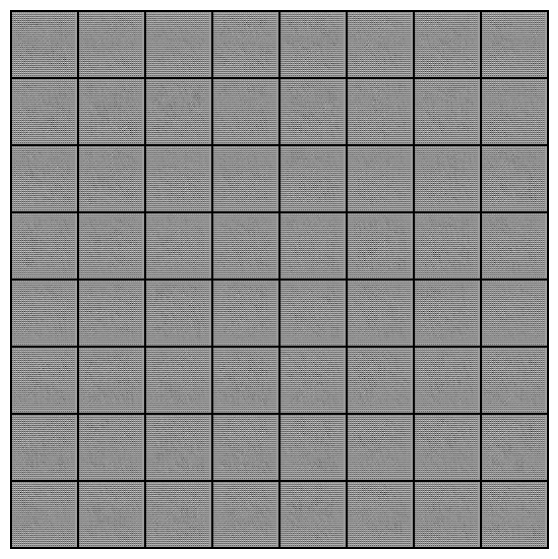

In [27]:
utils.set_seed()
noise = torch.randn(BS, 100)

tumor_labels = torch.randint(low = 0, high = 4, size = (BS,))
section_label = torch.randint(low = 0, high = 3, size = (BS,))
utils.generate_images(gen, noise, tumor_labels, section_label, BS)

In [33]:
load_pretrained = False
models_path = 'TabularDataGeneration/BrainTumor/Models/'

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

if load_pretrained:
  print('Parameters loaded!')
  crit.load_state_dict(torch.load(models_path + "TinyVGGcritic.pth"))
  gen.load_state_dict(torch.load(models_path + "TinyVGGgenerator.pth"))
else:
  print('Parameters initialized')
  crit.apply(weights_init)
  gen.apply(weights_init)

g_lr = 5e-4
c_lr = 2e-3

g_opt = torch.optim.Adam(gen.parameters(), lr = g_lr, betas = (0.5, 0.999))
c_opt = torch.optim.RMSprop(crit.parameters(), lr = c_lr, weight_decay = 0)

utils.set_seed()
z = torch.randn(BS, 100)

fixed_tumor_labels = torch.randint(low = 0, high = 4, size = (BS,))
fixed_section_label = torch.randint(low = 0, high = 3, size = (BS,))

Parameters initialized


Training Model:   0%|          | 0/101 [00:00<?, ?it/s]

Epoch0/100 | CLoss: -39.7712 | GLoss: 39.2625
Epoch0/100 | CLoss: -39.7712 | GLoss: 39.2625


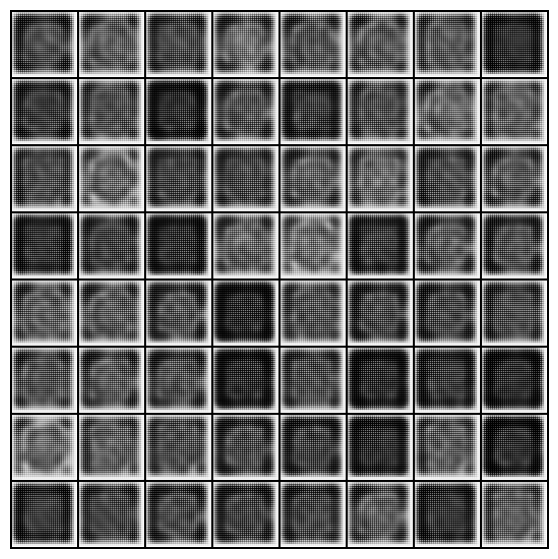

Epoch1/100 | CLoss: -23.7387 | GLoss: 13.3829
Epoch2/100 | CLoss: -27.4077 | GLoss: 11.3605
Epoch3/100 | CLoss: -27.7477 | GLoss: 33.5621
Epoch4/100 | CLoss: -26.8213 | GLoss: 22.1264
Epoch5/100 | CLoss: -25.0991 | GLoss: 32.9955
Epoch6/100 | CLoss: -23.4434 | GLoss: 27.9680
Epoch7/100 | CLoss: -21.5928 | GLoss: 15.5075
Epoch8/100 | CLoss: -20.1430 | GLoss: 10.3116
Epoch9/100 | CLoss: -19.1796 | GLoss: 14.6682
Epoch10/100 | CLoss: -18.2378 | GLoss: 25.8049
Epoch10/100 | CLoss: -18.2378 | GLoss: 25.8049


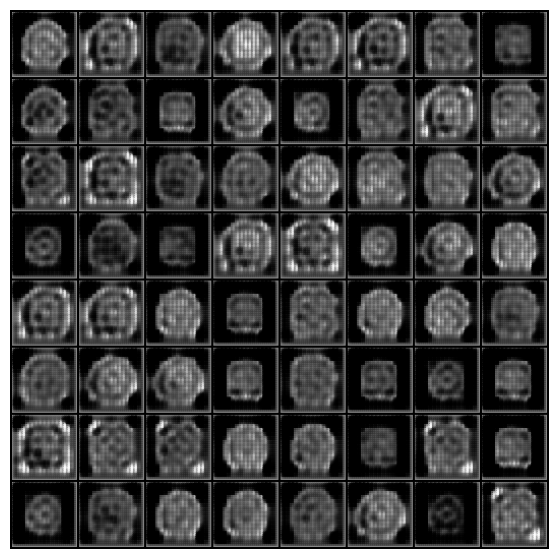

Epoch11/100 | CLoss: -17.4189 | GLoss: 28.6463
Epoch12/100 | CLoss: -16.6371 | GLoss: 36.4340
Epoch13/100 | CLoss: -16.2111 | GLoss: 41.9344
Epoch14/100 | CLoss: -15.5901 | GLoss: 43.9411
Epoch15/100 | CLoss: -15.1360 | GLoss: 44.7809
Epoch16/100 | CLoss: -14.7344 | GLoss: 36.7372
Epoch17/100 | CLoss: -14.3356 | GLoss: 57.5766
Epoch18/100 | CLoss: -13.9999 | GLoss: 64.6274
Epoch19/100 | CLoss: -13.5693 | GLoss: 62.7504
Epoch20/100 | CLoss: -13.1125 | GLoss: 69.9613
Epoch20/100 | CLoss: -13.1125 | GLoss: 69.9613


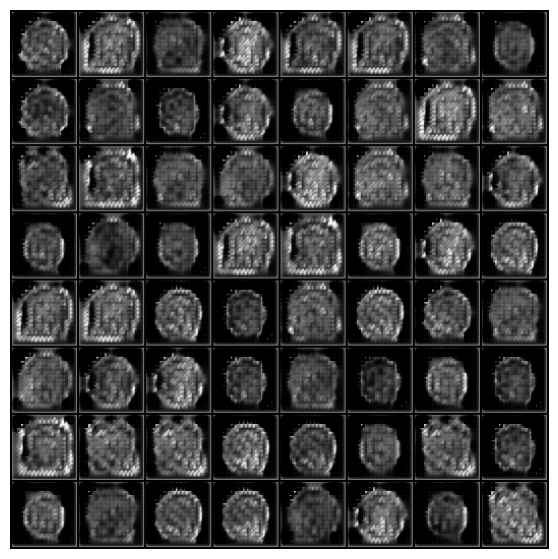

Epoch21/100 | CLoss: -12.7730 | GLoss: 75.8133
Epoch22/100 | CLoss: -12.4647 | GLoss: 73.2793
Epoch23/100 | CLoss: -12.2481 | GLoss: 67.5844
Epoch24/100 | CLoss: -12.0210 | GLoss: 71.9761
Epoch25/100 | CLoss: -11.7061 | GLoss: 79.4996
Epoch26/100 | CLoss: -11.4160 | GLoss: 69.5136
Epoch27/100 | CLoss: -11.8530 | GLoss: 71.2691
Epoch28/100 | CLoss: -11.7459 | GLoss: 78.1440
Epoch29/100 | CLoss: -11.6857 | GLoss: 79.4478
Epoch30/100 | CLoss: -11.4705 | GLoss: 80.3591
Epoch30/100 | CLoss: -11.4705 | GLoss: 80.3591


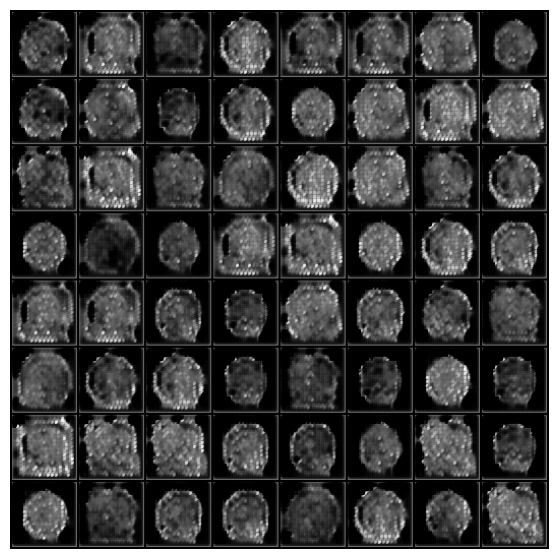

Epoch31/100 | CLoss: -11.0586 | GLoss: 58.5186
Epoch32/100 | CLoss: -11.1842 | GLoss: 50.2231
Epoch33/100 | CLoss: -11.0885 | GLoss: 50.1808
Epoch34/100 | CLoss: -10.9401 | GLoss: 50.2613
Epoch35/100 | CLoss: -10.8364 | GLoss: 54.2083
Epoch36/100 | CLoss: -10.6372 | GLoss: 55.5318
Epoch37/100 | CLoss: -10.4780 | GLoss: 55.2860
Epoch38/100 | CLoss: -10.3286 | GLoss: 59.1826
Epoch39/100 | CLoss: -10.1411 | GLoss: 66.7287
Epoch40/100 | CLoss: -9.9145 | GLoss: 64.5792
Epoch40/100 | CLoss: -9.9145 | GLoss: 64.5792


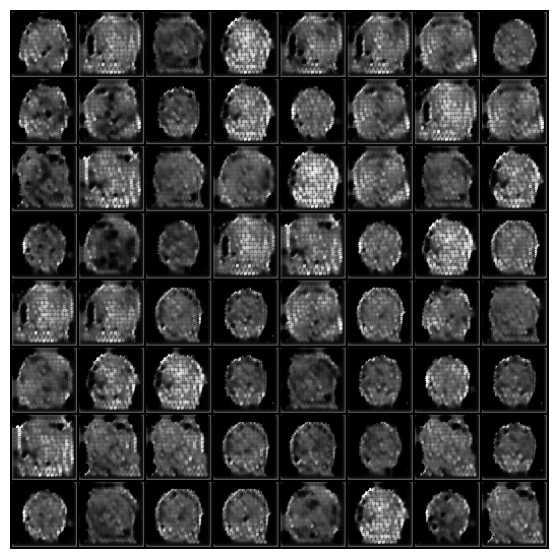

Epoch41/100 | CLoss: -9.8036 | GLoss: 65.5348
Epoch42/100 | CLoss: -9.4541 | GLoss: 89.5739
Epoch43/100 | CLoss: -9.4295 | GLoss: 91.3307
Epoch44/100 | CLoss: -9.2732 | GLoss: 90.6813
Epoch45/100 | CLoss: -9.2084 | GLoss: 94.4270
Epoch46/100 | CLoss: -8.9924 | GLoss: 81.2952
Epoch47/100 | CLoss: -8.8044 | GLoss: 90.2467
Epoch48/100 | CLoss: -8.7923 | GLoss: 104.1716
Epoch49/100 | CLoss: -8.6382 | GLoss: 107.0547
Epoch50/100 | CLoss: -8.4877 | GLoss: 103.1386
Epoch50/100 | CLoss: -8.4877 | GLoss: 103.1386


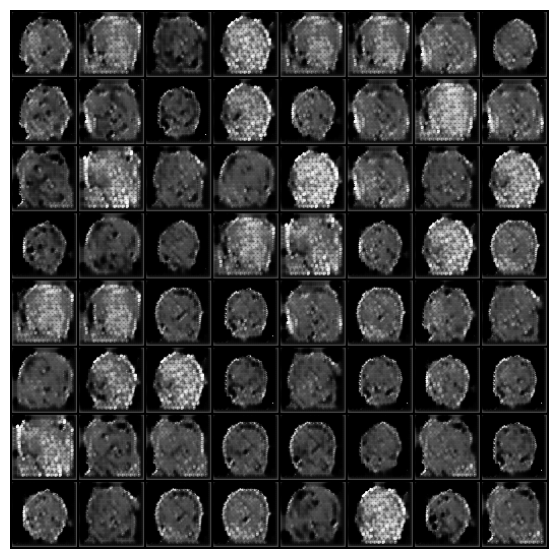

Epoch51/100 | CLoss: -8.4291 | GLoss: 111.4321
Epoch52/100 | CLoss: -8.2330 | GLoss: 113.3415
Epoch53/100 | CLoss: -8.1688 | GLoss: 116.7509
Epoch54/100 | CLoss: -8.0456 | GLoss: 120.2468
Epoch55/100 | CLoss: -7.8523 | GLoss: 115.3030
Epoch56/100 | CLoss: -7.6965 | GLoss: 114.9200
Epoch57/100 | CLoss: -7.6745 | GLoss: 119.0853
Epoch58/100 | CLoss: -7.4842 | GLoss: 113.7184
Epoch59/100 | CLoss: -7.4783 | GLoss: 110.8046
Epoch60/100 | CLoss: -7.3048 | GLoss: 111.0315
Epoch60/100 | CLoss: -7.3048 | GLoss: 111.0315


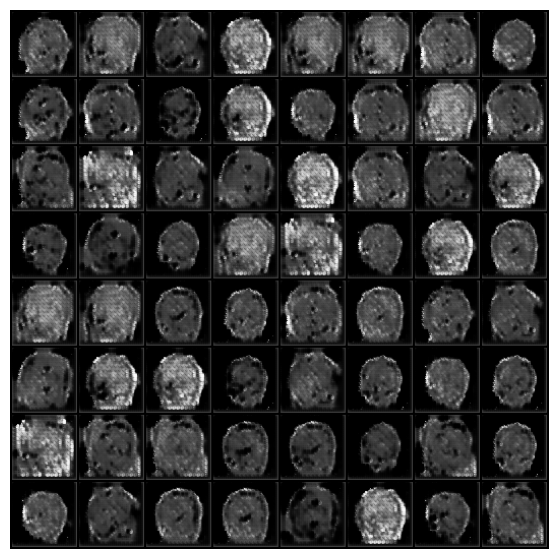

Epoch61/100 | CLoss: -7.2548 | GLoss: 109.9712
Epoch62/100 | CLoss: -7.0767 | GLoss: 106.6330
Epoch63/100 | CLoss: -7.0379 | GLoss: 105.7143
Epoch64/100 | CLoss: -6.8576 | GLoss: 102.0613
Epoch65/100 | CLoss: -6.7984 | GLoss: 101.4540
Epoch66/100 | CLoss: -6.6980 | GLoss: 98.3804
Epoch67/100 | CLoss: -6.6249 | GLoss: 99.5711
Epoch68/100 | CLoss: -6.5207 | GLoss: 97.3773
Epoch69/100 | CLoss: -6.4841 | GLoss: 97.1842
Epoch70/100 | CLoss: -6.3523 | GLoss: 93.8827
Epoch70/100 | CLoss: -6.3523 | GLoss: 93.8827


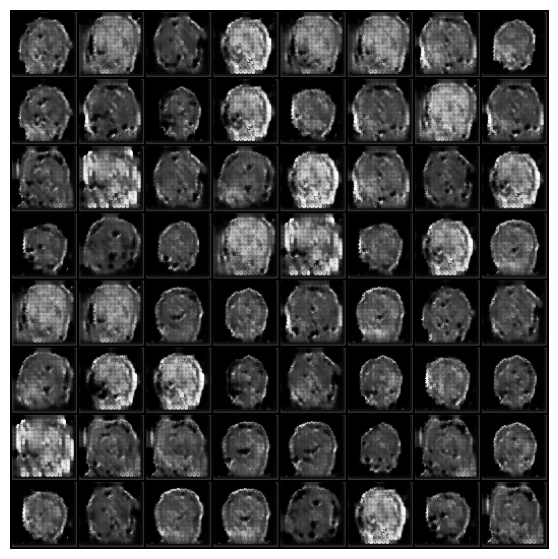

Epoch71/100 | CLoss: -6.2511 | GLoss: 89.1019
Epoch72/100 | CLoss: -6.2456 | GLoss: 92.2912
Epoch73/100 | CLoss: -5.9990 | GLoss: 86.6532
Epoch74/100 | CLoss: -5.9976 | GLoss: 88.8077
Epoch75/100 | CLoss: -5.8685 | GLoss: 89.8432
Epoch76/100 | CLoss: -5.8042 | GLoss: 89.4163
Epoch77/100 | CLoss: -5.6839 | GLoss: 90.0927
Epoch78/100 | CLoss: -5.6528 | GLoss: 93.9921
Epoch79/100 | CLoss: -5.5277 | GLoss: 91.5081
Epoch80/100 | CLoss: -5.5627 | GLoss: 94.0653
Epoch80/100 | CLoss: -5.5627 | GLoss: 94.0653


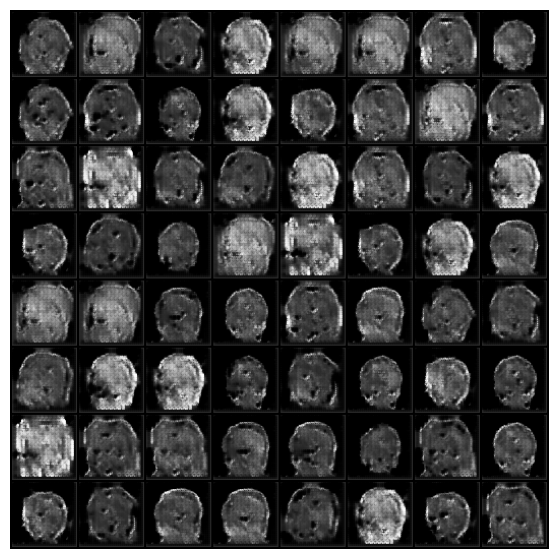

Epoch81/100 | CLoss: -5.5340 | GLoss: 94.2424
Epoch82/100 | CLoss: -5.4214 | GLoss: 91.9335
Epoch83/100 | CLoss: -5.3407 | GLoss: 89.7129
Epoch84/100 | CLoss: -5.2924 | GLoss: 87.1900
Epoch85/100 | CLoss: -5.2177 | GLoss: 85.4958
Epoch86/100 | CLoss: -5.1489 | GLoss: 82.2576
Epoch87/100 | CLoss: -5.0527 | GLoss: 78.8097
Epoch88/100 | CLoss: -4.9272 | GLoss: 75.8768
Epoch89/100 | CLoss: -4.9444 | GLoss: 73.4970
Epoch90/100 | CLoss: -4.8947 | GLoss: 78.6608
Epoch90/100 | CLoss: -4.8947 | GLoss: 78.6608


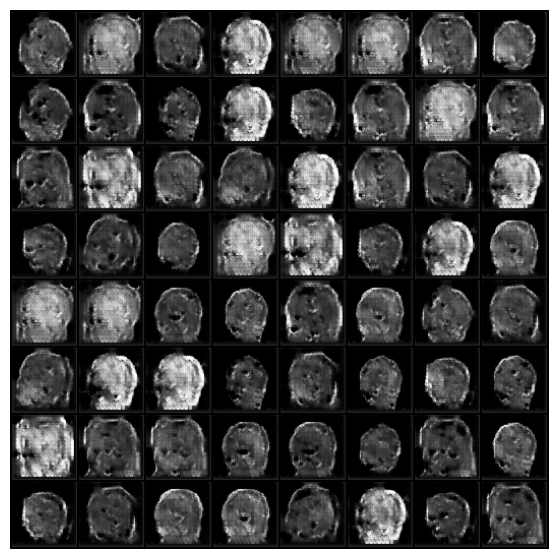

Epoch91/100 | CLoss: -4.8140 | GLoss: 78.6357
Epoch92/100 | CLoss: -4.8097 | GLoss: 74.2707
Epoch93/100 | CLoss: -4.7165 | GLoss: 72.5537
Epoch94/100 | CLoss: -4.6514 | GLoss: 76.0422
Epoch95/100 | CLoss: -4.6732 | GLoss: 78.3464
Epoch96/100 | CLoss: -4.5546 | GLoss: 77.8073
Epoch97/100 | CLoss: -4.5595 | GLoss: 75.3969
Epoch98/100 | CLoss: -4.5519 | GLoss: 72.8698
Epoch99/100 | CLoss: -4.5184 | GLoss: 78.5988
Epoch100/100 | CLoss: -4.4739 | GLoss: 77.3944
Epoch100/100 | CLoss: -4.4739 | GLoss: 77.3944


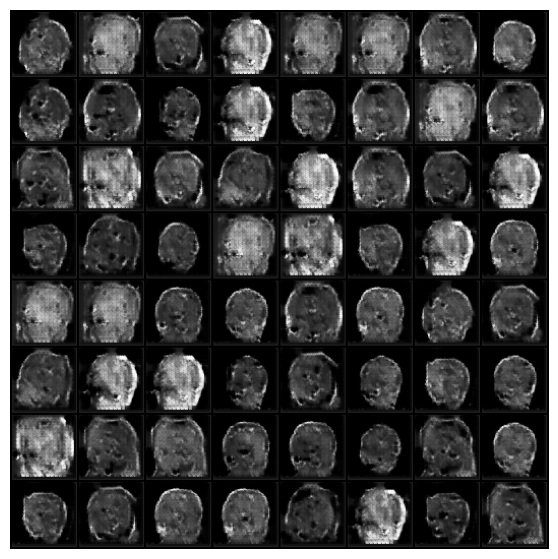

In [34]:
epochs = 100
verbose = 0.1
noise_dim = 100

for epoch in tqdm(range(epochs + 1), desc = 'Training Model'):

  gen = gen.to(device)
  crit = crit.to(device)

  gen.train()
  crit.train()

  gen_epoch_loss = 0
  crit_epoch_loss = 0

  for data, labels in dataloader:

    data = data.to(device)
    tumor_labels = labels[0].to(device)
    section_labels = labels[1].to(device)

    noise = torch.randn(data.shape[0], noise_dim).to(device)
    fake_data = gen(noise, tumor_labels, section_labels)

    c_opt.zero_grad()
    crit_loss = critic_loss(crit, data, fake_data, tumor_labels, section_labels)
    crit_epoch_loss += crit_loss.item()
    crit_loss.backward()
    c_opt.step()

  #if epoch % 2 == 0:

    noise = torch.randn(data.shape[0], noise_dim).to(device)
    fake_data = gen(noise, tumor_labels, section_labels)

    g_opt.zero_grad()
    gen_loss = generator_loss(crit, fake_data, tumor_labels, section_labels)
    gen_epoch_loss += gen_loss.item()
    gen_loss.backward()
    g_opt.step()

  g_epoch_loss = gen_epoch_loss/len(dataloader)
  c_epoch_loss = crit_epoch_loss/len(dataloader)
  print(f"Epoch{epoch}/{epochs} | CLoss: {c_epoch_loss:.4f} | GLoss: {g_epoch_loss:.4f}")

  if epoch % (epochs * 0.1) == 0 or epoch == epochs:
    print(f"Epoch{epoch}/{epochs} | CLoss: {c_epoch_loss:.4f} | GLoss: {g_epoch_loss:.4f}")
    utils.generate_images(gen, z, fixed_tumor_labels, fixed_section_label, BS)

In [39]:
#torch.save(crit.state_dict(), "TinyVGGcritic.pth")
#torch.save(gen.state_dict(), "TinyVGGgenerator.pth")